In [0]:
# Native Python Library
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
from PIL import Image
import pandas as pd
import math
import scipy.misc
import tensorflow as tf
import imageio
from scipy import misc
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation,Dense, Dropout, Flatten, BatchNormalization, Input,GlobalAveragePooling2D
import ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context   
config = tf.ConfigProto(allow_soft_placement = True)
sess = tf.Session(config=config) 
tf.keras.backend.set_session(sess)

In [0]:
#configuration 
IMAGE_H = 299
IMAGE_W = 299
batch_size = 128

In [0]:
train_data_file_path = "/root/deeplearning/train2014"
label_data_file_path = "/root/deeplearning"

# Load the train data and resize them to 299*299

In [0]:
# load all the image file into numpy array may take 2minutes according to image size (148sec for size 224*224)
import time
start = time. time()

os.chdir(train_data_file_path)
train_file_list = os.listdir(train_data_file_path)
# load the train data
train_data = np.array([np.array(cv2.resize( cv2.imread(filename), (IMAGE_H,IMAGE_W))) for filename in train_file_list])
train_data_file_name = pd.DataFrame(np.array([filename for filename in train_file_list]))
train_data_file_name.columns = ['filename']

end = time. time()
print(end - start)

230.35574626922607


# Load the test data and resize them to 299*299

In [0]:
valid_data_file_path = "/root/deeplearning/val2014"
os.chdir(valid_data_file_path)
valid_file_list = os.listdir(valid_data_file_path)
valid_data =  np.array([np.array(cv2.resize( cv2.imread(filename), (IMAGE_H,IMAGE_W))) for filename in valid_file_list])
valid_data_file_name = pd.DataFrame(np.array([filename for filename in os.listdir(valid_data_file_path)]))
valid_data_file_name.columns = ['filename']

# Load the train label

In [0]:
# Read all train label from local devices
os.chdir(label_data_file_path)
train_label_file =  pd.read_csv(label_data_file_path + '/train.txt', sep='\t', names=['filename','label'])
train_label = pd.merge(train_data_file_name, train_label_file,on='filename')[['label']]
train_label = np.array(train_label).T[0]


In [0]:
#process data using one hot 
duplicate_train_label = train_label
label_list = np.ndarray.tolist(duplicate_train_label)

result_set = []
for item in label_list:
    if item.find(",")!=-1:
        array = item.split(",")
        item = set(array)
        result_set.append(item)
    else:     
        item = {item}
        result_set.append(item)
        
real_label = np.zeros((len(result_set),20))
for i in range(real_label.shape[0]):
    for d in result_set[i]:
        real_label[i][int(d)] = 1

#Split data using train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_data,real_label,test_size=0.2, random_state=42)

# DenseNet201 model

In [0]:
# use pretrained model resnet50 and add several fully connected layer
input_shape = (IMAGE_H, IMAGE_W, 3)
inputs = Input(shape=input_shape)
pretrained_model = DenseNet201(include_top=False,
                      weights='imagenet',
                      input_shape=input_shape
                      )
x = pretrained_model(inputs)

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)

outputs = Dense(20, activation='sigmoid')(x)
model = Model(inputs, outputs)
model.layers[1].trainable = False
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train 80% data, test 20%

In [0]:
# save the accuracy and loss for each epoch
val_acc = []
val_loss = []
# train with 8 epochs
for j in range(0,8):
    history = model.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=1,
            verbose=1,
            validation_data=(X_test, Y_test))
    y_predict = model.predict(X_test)
    top_1 = np.array([np.argmax(i) for i in y_predict])
    count = 0
    for i in range(len(top_1)):
        if Y_test[i,top_1[i]] == 1:
            count += 1
    print(count/len(top_1))
    val_acc.append(count/len(top_1))
    val_loss.append(history.history['val_loss'])

Train on 25540 samples, validate on 6385 samples
25540/25540 [==============================] - 206s 8ms/sample - loss: 0.1433 - acc: 0.9487 - val_loss: 0.1152 - val_acc: 0.9568
0.6867658574784652
Train on 25540 samples, validate on 6385 samples
25540/25540 [==============================] - 193s 8ms/sample - loss: 0.1082 - acc: 0.9596 - val_loss: 0.1078 - val_acc: 0.9600
0.7158966327329679
Train on 25540 samples, validate on 6385 samples
25540/25540 [==============================] - 193s 8ms/sample - loss: 0.1012 - acc: 0.9620 - val_loss: 0.1065 - val_acc: 0.9602
0.7201252936570086
Train on 25540 samples, validate on 6385 samples
25540/25540 [==============================] - 193s 8ms/sample - loss: 0.0965 - acc: 0.9636 - val_loss: 0.1054 - val_acc: 0.9607
0.7194988253719655
Train on 25540 samples, validate on 6385 samples
25540/25540 [==============================] - 193s 8ms/sample - loss: 0.0925 - acc: 0.9648 - val_loss: 0.1065 - val_acc: 0.9608
0.7215348472983555
Train on 25540 

# Train the entire dataset

In [0]:

# train with 8 epochs by entire train set
for j in range(0,8):
    history = model.fit(train_data, real_label,
            batch_size=batch_size,
            epochs=1,
            verbose=1,
            validation_data=(X_test, Y_test))
    

Train on 31925 samples, validate on 6385 samples
31925/31925 [==============================] - 245s 8ms/sample - loss: 0.1381 - acc: 0.9503 - val_loss: 0.1085 - val_acc: 0.9597
Train on 31925 samples, validate on 6385 samples
31925/31925 [==============================] - 232s 7ms/sample - loss: 0.1069 - acc: 0.9602 - val_loss: 0.1020 - val_acc: 0.9615
Train on 31925 samples, validate on 6385 samples
31925/31925 [==============================] - 232s 7ms/sample - loss: 0.1009 - acc: 0.9621 - val_loss: 0.0945 - val_acc: 0.9641
Train on 31925 samples, validate on 6385 samples
31925/31925 [==============================] - 232s 7ms/sample - loss: 0.0963 - acc: 0.9637 - val_loss: 0.0953 - val_acc: 0.9641
Train on 31925 samples, validate on 6385 samples
31925/31925 [==============================] - 232s 7ms/sample - loss: 0.0936 - acc: 0.9645 - val_loss: 0.0890 - val_acc: 0.9660
Train on 31925 samples, validate on 6385 samples
31925/31925 [==============================] - 232s 7ms/sampl

In [0]:
model.save('final_model_densenet201.h5')

In [0]:
x_predict = model.predict(valid_data)


In [0]:
import sys
file = open('final_2.txt','w')
for i in range(0, valid_data.shape[0]):
    file.write(valid_data_file_name['filename'][i]+"\t")
    file.write(str(np.argmax(x_predict[i])) + '\n')

# Plot the accuracy and loss graph

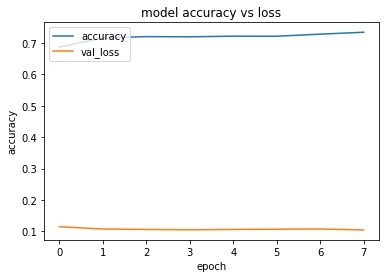

In [0]:
plt.plot(val_acc)
plt.plot(val_loss)
plt.title('model accuracy vs loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_loss'], loc='upper left')
plt.show()